# Variational Autoencoder for Audio
In this notebook, I will attempt to implement a VAE for generating similar sounds as those in a Spoken Digit audio Database. 

In [1]:
%matplotlib inline
import IPython.display

import gzip
import cPickle as pickle
import pandas as pd
import random
import seaborn
import librosa

from librosa.display import waveplot, specshow
seaborn.set(style='ticks')

In [2]:
dbfile ='../SpokenDigitDB.pkl.gz'
with gzip.open(dbfile, 'rb') as ifile:
    df = pickle.load(ifile)
    print('File loaded as '+ dbfile)    

File loaded as ../SpokenDigitDB.pkl.gz


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4509 entries, 0 to 4508
Data columns (total 7 columns):
Class        4509 non-null category
Magnitude    4509 non-null object
PShift       4509 non-null int64
Phase        4509 non-null object
SIndex       4509 non-null int64
TStretch     4509 non-null float64
Wave         4509 non-null object
dtypes: category(1), float64(1), int64(2), object(3)
memory usage: 215.9+ KB


Maximum length is: 138 


(array([  60.,   63.,  123.,  138.,  123.,  180.,  177.,  180.,  186.,
         135.,  276.,  171.,  255.,  216.,  195.,  174.,  174.,  132.,
         111.,  156.,  225.,  126.,  162.,   90.,   90.,   54.,   27.,
          72.,   42.,   33.,   75.,   57.,   39.,   42.,   15.,   33.,
          15.,   12.,    9.,    6.,    6.,    3.,    3.,   12.,    3.,
           3.,    9.,    3.,    9.,    9.]),
 array([  33. ,   35.1,   37.2,   39.3,   41.4,   43.5,   45.6,   47.7,
          49.8,   51.9,   54. ,   56.1,   58.2,   60.3,   62.4,   64.5,
          66.6,   68.7,   70.8,   72.9,   75. ,   77.1,   79.2,   81.3,
          83.4,   85.5,   87.6,   89.7,   91.8,   93.9,   96. ,   98.1,
         100.2,  102.3,  104.4,  106.5,  108.6,  110.7,  112.8,  114.9,
         117. ,  119.1,  121.2,  123.3,  125.4,  127.5,  129.6,  131.7,
         133.8,  135.9,  138. ]),
 <a list of 50 Patch objects>)

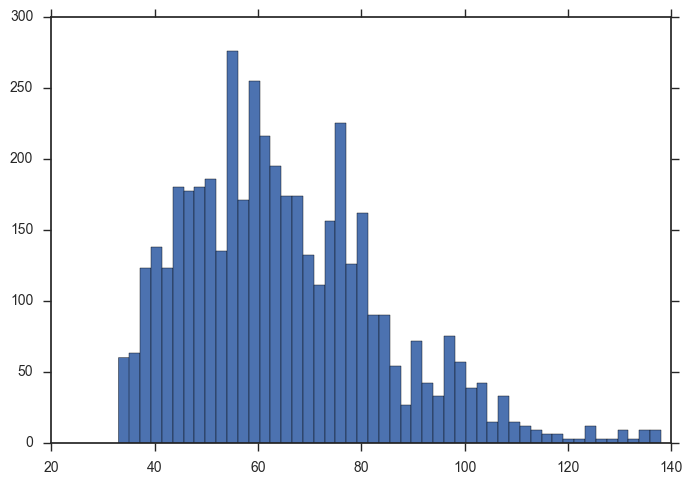

In [4]:
mag = df.Magnitude
mgs = [np.shape(x)[1] for x in mag]
maxlen = np.max(mgs)
print('Maximum length is: {} '.format(maxlen))
plt.hist(mgs,50)

In [5]:
# Padding & Truncating
maxlen = 84
pad    = lambda a, n: a[:,0: n] if a.shape[1] > n else np.hstack((a, np.zeros([a.shape[0],n - a.shape[1]])))

df.Magnitude = df.Magnitude.apply(pad,args=(maxlen,))  # MaxLen Truncation Voodoo :D
df.Phase     = df.Phase.apply(pad,args=(maxlen,))

print(np.unique([np.shape(x)[1] for x in df.Magnitude]))
print(np.unique([np.shape(x)[1] for x in df.Phase]))

[84]
[84]


## Plot Samples from Database

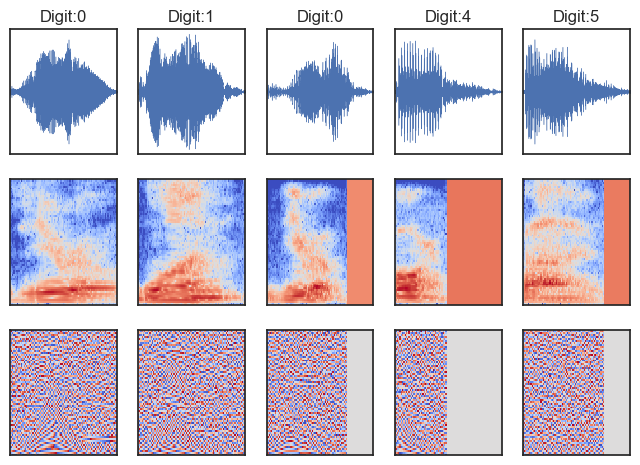

In [6]:
seaborn.set(style='white')

# Plot K Random Examples
k  = 5
sr = 8000

sidx = random.sample(range(len(df)),k)
sidx = np.append(sidx,[sidx,sidx])    

for i,j in enumerate(sidx):
    if i<k:
        subplot(3,k,i+1)
        waveplot(df.Wave[j],sr=sr)
        title('Digit:{1}'.format(j,df.Class[j]))
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        gca().get_xaxis().set_visible(False)

    elif (i>=k and i<2*k):
        subplot(3,k,i+1)
        specshow(df.Magnitude[j],sr=sr)
        gca().set_xticklabels([])
        gca().set_yticklabels([])
        
    else:
        subplot(3,k,i+1)
        specshow(df.Phase[j],sr=sr)
        gca().set_xticklabels([])
        gca().set_yticklabels([])        

In [7]:
# np.max(df.Magnitude[j])
# np.max(df.Phase[j])

## Playback & Reconstruction

In [8]:
# Play back an example!
j = sidx[1]
IPython.display.Audio(data=df.Wave[j], rate=sr)

In [9]:
# Reconstruct Audio from Spectrogram
def audio_recon(mag,phi):
    nfft = 128
    hop  = nfft/2
    mag = librosa.db_to_amplitude(mag)           # 1: convert magnitude from db to amplitude
    phi = np.cos(phi) + 1j*np.sin(phi)           # 2: convert phase from angle to phasor/complex
    wav = librosa.istft(mag*phi, hop_length=hop) # 3: compute stft as -  Magnitude * Phase    
    return wav

yo = df.Wave[j]    
yr = audio_recon(df.Magnitude[j],df.Phase[j])
IPython.display.Audio(data=yr, rate=sr)

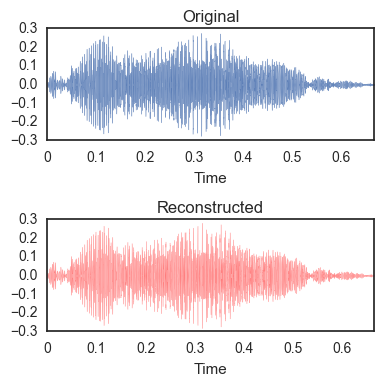

In [10]:
# Compare reconstructed with original
plt.figure(figsize=(4,4))
plt.subplot(211)
librosa.display.waveplot(yo,sr=sr,alpha=0.7)
plt.title('Original')

plt.subplot(212)
librosa.display.waveplot(yr[:len(yo)],sr=sr,color='r',alpha=0.3)
plt.title('Reconstructed')
plt.tight_layout()

## VAE for Audio

In [11]:
# Imports
from keras.layers import Input, Dense, Lambda, Flatten, Reshape, Layer
from keras.layers import Conv2D, Conv2DTranspose
from keras.models import Model
from keras import backend as K
from keras.callbacks import TensorBoard

from keras import metrics
from sklearn.utils import shuffle
from scipy.stats import norm
import keras

Using TensorFlow backend.


In [12]:
chns, rows, cols = 1, 64, 84
filters = 8

batch_size = 10
latent_dim = 10
middle_dim = 128

epochs = 25
epsilon_std = 1.0
img_size = (rows,cols,chns)

In [13]:
x_mag = Input(shape=img_size,name='magnitude')
x_phi = Input(shape=img_size,name='phase')

# Mag Encoder
mconv1 = Conv2D(filters,(3,5),padding='same',activation='relu',strides=(2,3))(x_mag)
mconv2 = Conv2D(filters,(3,3),padding='same',activation='relu',strides=(2,2))(mconv1)
mconv  = Flatten()(mconv2)

# Phi Encoder
pconv1 = Conv2D(filters,(3,5),padding='same',activation='relu',strides=(2,3))(x_phi)
pconv2 = Conv2D(filters,(3,3),padding='same',activation='relu',strides=(2,2))(pconv1)
pconv  = Flatten()(pconv2)


# Intermediate Shared Layer - Encoder
shared_layer = Dense(middle_dim, activation='relu')
encoded_m = shared_layer(mconv)
encoded_p = shared_layer(pconv)
# encoded   = K.concatenate([encoded_m, encoded_p], axis=-1)
encoded   = keras.layers.concatenate([encoded_m, encoded_p])

# Latent Distribution
z_mean = Dense(latent_dim)(encoded)
z_lvar = Dense(latent_dim)(encoded)

In [14]:
# Gaussian Sampler
def sampling(args):
    z_mean, z_lvar = args
    bsize = K.shape(z_mean)[0]
    epsilon = K.random_normal(shape=(bsize, latent_dim),
                              mean=0.0, stddev=epsilon_std)
    return z_mean + K.exp(z_lvar / 2) * epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_lvar])

In [15]:
# Intermediate Shared Layer - Decoder
decode_h = Dense(middle_dim, activation='relu')

# Mag Decoder
decode_m   = decode_h(z)
upsample_m = Dense(filters*16*14, activation='relu')(decode_m)
ureshape_m = Reshape((16,14,filters))(upsample_m)
trconv1_m  = Conv2DTranspose(filters,3,padding='same',
                          activation='relu',strides=2)(ureshape_m)
trconv2_m  = Conv2DTranspose(filters,(3,5),padding='same',
                          activation='relu',strides=(2,3))(trconv1_m)
decoded_m  = Conv2D(chns,2,padding='same',activation='relu',name='decoded_mag')(trconv2_m)


# Phi Decoder
decode_p   = decode_h(z)
upsample_p = Dense(filters*16*14, activation='relu')(decode_p)
ureshape_p = Reshape((16,14,filters))(upsample_p)
trconv1_p  = Conv2DTranspose(filters,3,padding='same',
                          activation='relu',strides=2)(ureshape_p)
trconv2_p  = Conv2DTranspose(filters,(3,5),padding='same',
                          activation='relu',strides=(2,3))(trconv1_p)
decoded_p  = Conv2D(chns,2,padding='same',activation='relu',name='decoded_phi')(trconv2_p)

In [16]:
def vae_loss(x, decoded):
    x = K.flatten(x)
    decoded = K.flatten(decoded)
    gen_loss = rows * cols * metrics.binary_crossentropy(x, decoded)
    kl_loss = - 0.5 * K.mean(1 + z_lvar - K.square(z_mean) - K.exp(z_lvar), axis=-1)
    return K.mean(gen_loss + kl_loss)

# Model
vae = Model(inputs=[x_mag, x_phi], outputs=[decoded_m, decoded_p])
vae.compile(optimizer='adam', loss=vae_loss, loss_weights=[1.0,0.5])
vae.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
magnitude (InputLayer)           (None, 64, 84, 1)     0                                            
____________________________________________________________________________________________________
phase (InputLayer)               (None, 64, 84, 1)     0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 32, 28, 8)     128         magnitude[0][0]                  
____________________________________________________________________________________________________
conv2d_3 (Conv2D)                (None, 32, 28, 8)     128         phase[0][0]                      
___________________________________________________________________________________________

In [17]:
# Model(inputs = [x_mag,x_phi],outputs=z_mean)

In [18]:
import tensorflow as tf

with tf.Session() as sess:
    writer = tf.summary.FileWriter('logs', sess.graph)
#     print sess.run(golden_ratio)
    writer.close()

In [19]:
# Encoder
encoder = Model(inputs=[x_mag,x_phi],outputs=z_mean)

# Generator
# dd_in = Input(shape=(latent_dim,))
# dd = decode_h(dd_in)
# dd = ureshape(dd)
# dd = trconv1(dd)
# dd = trconv2(dd)
# dd = decoded(dd)
# generator = Model(dd_in,dd) 
generator = Model([x_mag,x_phi],[decoded_m,decoded_p])

## Transform Training Data & Train

In [20]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

## Magnitude Data - Scale to Norm 1
# Train Scaler
xm_data = df.Magnitude.values
normsc = np.hstack(xm_data)
mscaler = MinMaxScaler().fit(normsc.T)

# Transform Data using Scaler
xm_data = [mscaler.transform(arr.T).T for arr in df.Magnitude.values]
xm_data = np.dstack(xm_data).transpose(2,0,1)
xm_data = xm_data[...,None]         # Add singleton class

## Phase Data - Scale to Norm 1
# Train Scaler
xp_data = df.Phase.values
normsc = np.hstack(xp_data)
pscaler = MinMaxScaler().fit(normsc.T)

# Transform Data using Scaler
xp_data = [pscaler.transform(arr.T).T for arr in df.Phase.values]
xp_data = np.dstack(xp_data).transpose(2,0,1)
xp_data = xp_data[...,None]

In [21]:
vae.fit([xm_data,xp_data],[xm_data,xp_data],
        shuffle=True,
        epochs=15,
        batch_size=50,
        callbacks=[TensorBoard(log_dir='logs')])

Epoch 1/15
4509/4509 [==============================] - 18s - loss: 10109.0416 - decoded_mag_loss: 6732.2470 - decoded_phi_loss: 6753.5890    
Epoch 2/15
4509/4509 [==============================] - 18s - loss: 5501.4869 - decoded_mag_loss: 3560.9227 - decoded_phi_loss: 3881.1283    
Epoch 3/15
4509/4509 [==============================] - 17s - loss: 5347.4669 - decoded_mag_loss: 3449.8379 - decoded_phi_loss: 3795.2582    
Epoch 4/15
4509/4509 [==============================] - 19s - loss: 5261.6300 - decoded_mag_loss: 3378.3979 - decoded_phi_loss: 3766.4642    
Epoch 5/15
4509/4509 [==============================] - 19s - loss: 5207.2660 - decoded_mag_loss: 3333.0423 - decoded_phi_loss: 3748.4473    
Epoch 6/15
4509/4509 [==============================] - 19s - loss: 5187.9903 - decoded_mag_loss: 3317.6840 - decoded_phi_loss: 3740.6127    
Epoch 7/15
4509/4509 [==============================] - 19s - loss: 5158.6542 - decoded_mag_loss: 3290.7142 - decoded_phi_loss: 3735.8801    
Epoch

In [ ]:
# k=0
# ymag,yphi = generator.predict([xm_data[k:k+1],xp_data[k:k+1]])

In [22]:
ymag,yphi = generator.predict([xm_data,xp_data],batch_size=50)

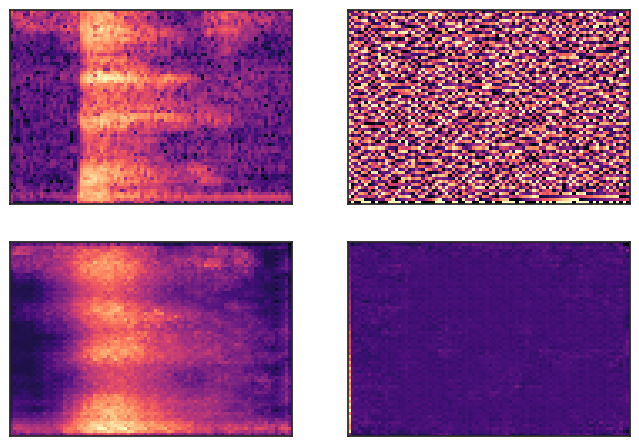

In [55]:
k = np.random.randint(0,len(xm_data))
subplot(221)
ss=xm_data[k].squeeze()
specshow(ss,sr=sr)

subplot(222)
ss=xp_data[k].squeeze()
specshow(ss,sr=sr)

subplot(223)
ss=ymag[k].squeeze()
specshow(ss,sr=sr)

subplot(224)
ss=yphi[k].squeeze()
specshow(ss,sr=sr)

In [56]:
xxm = xm_data[k].squeeze()
xxp = xm_data[k].squeeze()

yym = ymag[k].squeeze()
yyp = yphi[k].squeeze()

xxm = mscaler.inverse_transform(xxm.T).T
xxp = pscaler.inverse_transform(xxp.T).T

yym = mscaler.inverse_transform(yym.T).T
yyp = pscaler.inverse_transform(yyp.T).T

In [57]:
yo = audio_recon(xxm,xxp)   
IPython.display.Audio(data=yo, rate=sr)

In [60]:
yr = audio_recon(yym,yyp)
IPython.display.Audio(data=yr, rate=sr)

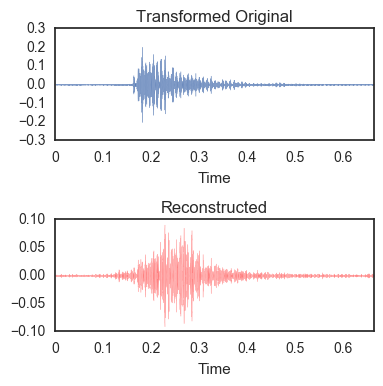

In [59]:
# Compare reconstructed with original
plt.figure(figsize=(4,4))
plt.subplot(211)
librosa.display.waveplot(yo,sr=sr,alpha=0.7)
plt.title('Transformed Original')

plt.subplot(212)
librosa.display.waveplot(yr[:len(yo)],sr=sr,color='r',alpha=0.3)
plt.title('Reconstructed')
plt.tight_layout()